In [1]:
from useful_functions import *
import ast
from varname import nameof
savePNG = True ## Changes matplotlib backend to save plots as pgf (default:True)
if savePNG:
    mpl.use("agg")
    plotExt = str('.png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotExt = str('.pgf')

notebookPlotFlag = False ## Changes Jupyter plotting backend (default:True)
if notebookPlotFlag:
    %matplotlib notebook
elif not notebookPlotFlag:
    %matplotlib inline

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')[::2]
tess_2020bpi['mjd_0'] = tess_2020bpi['mjd'] - tess_2020bpi['mjd'].min()
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_raw_flux,bkg_model_flux,flux,e_flux,mjd_0
0,1870.44408,58869.94408,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.001725,0.007501,0.00000
2,1870.46491,58869.96491,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006505,0.007536,0.02083
4,1870.48574,58869.98574,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018823,0.007675,0.04166
6,1870.50658,58870.00658,-10843.6913,1370.6601,1501.2344,-0.062277,0.007872,0.008622,-0.028431,0.007510,0.06250
8,1870.52741,58870.02741,-9069.4821,1365.9754,1501.2344,-0.052088,0.007845,0.008622,-0.018710,0.007485,0.08333


In [3]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['mjd_0'] = ztf_2020bpi['mjd'] - tess_2020bpi['mjd'].min()
## Note: setting the zero value of mjd_0 to that of TESS for consitency 
ztf_2020bpi['e_flux_tuple'] = ztf_2020bpi['e_flux']
ztf_2020bpi['e_flux'] = [
    np.mean(ast.literal_eval(flux))
    for flux in ztf_2020bpi['e_flux'].to_numpy()
                        ]

ztf_2020bpi.head()

,BTJD,mjd,magap,sig_magap,flux,e_flux,mjd_0,e_flux_tuple
0,1879.870567,58879.370567,19.729799,0.2218,0.014224,0.002926,9.426487,"(0.002628163767600394, 0.003223832161130714)"
1,1881.011065,58880.511065,19.959801,0.2436,0.011509,0.002604,10.566985,"(0.0023129338055085068, 0.0028946976073013723)"
2,1881.031343,58880.531343,19.473101,0.1538,0.018018,0.002561,10.587263,"(0.0023797689104727814, 0.002741920034638759)"
3,1881.843854,58881.343854,19.660400,0.2291,0.015163,0.003223,11.399774,"(0.0028844699689605166, 0.003562099310207071)"
4,1882.032546,58881.532546,19.363001,0.1425,0.019941,0.002625,11.588466,"(0.00245268546717093, 0.0027966740782900297)"


In [93]:
import emcee
import corner
from multiprocessing import Pool

def get_fullparam(theta, thetaKeys):
    params = {
        't0':5,
        'a':0.01, 
        'sigma':0, 
        'power':1.8
    }
#     print('params1: ', params)
#     print('theta: ',theta)
#     print('dict:',dict(zip(thetaKeys,theta)))
    params.update(dict(zip(thetaKeys,theta)))
#     print('params2: ', params)
    ## .update() adds keyed values as well; might need 
    ## to find new method to account for this
    #print(params)
    return params

def lc_model(theta,thetaKeys, data):
    thetaDict = get_fullparam(theta,thetaKeys)
    var = (data['e_flux']**2 + thetaDict['sigma']**2)
    model = [0 if t <= thetaDict['t0'] else
             thetaDict['a'] * (t - thetaDict['t0'])**thetaDict['power'] 
             for t in data['mjd_0']]
    return model, var

def log_prior(theta, thetaKeys):
    
    nparam = len(theta)
    thetaDict = get_fullparam(theta, thetaKeys)
    
    logpr = 0.

#     if nparam <= 2:
#         return logpr

    if thetaDict['sigma'] < 0:
        return -np.inf

    if thetaDict['t0'] < 0:
        return -np.inf
    
    if thetaDict['t0'] > 10:
        return -(100)**np.float(thetaDict['t0'])
    
    if thetaDict['a'] <= 0 or thetaDict['a'] >= 10:
        return -np.inf
    
    if thetaDict['power'] <= 1:
        return -np.inf
    
    if thetaDict['power'] >= 2.5:
        return -(1000)**np.float(thetaDict['power'])
    return logpr

def log_likelihood(theta, thetaKeys, data):
    
    thetaDict = get_fullparam(theta, thetaKeys)
    #print(thetaDict)
    model,var = lc_model(thetaDict.values(),thetaDict.keys(),data)
    
    logl = -0.5 * (np.sum(np.log(2 * np.pi * var) + 
                            ((data['flux'] - model)**2 / var) ))
        
    return logl

    
def log_posterior(theta, thetaKeys, data):
    
    logpr = log_prior(theta, thetaKeys)
    
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(theta, thetaKeys, data)

def doMCMC(data, guess, scale, nwalkers=100, nburn=1500, nsteps=3000):
    '''
    Takes data which contains mjd and flux data
    and performs an mcmc fit on it
    '''
    ndim = len(guess)
    assert ndim == len(scale)

    starting_guesses = np.swapaxes(list({
        k:(np.random.randn(nwalkers)*scale[k]+v)
        for k,v in guess.items()}.values()),0,1)
#     print(starting_guesses)
    print('sampling...')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                    threads=-1, args=[list(guess.keys()),data])
    sampler.run_mcmc(starting_guesses, nsteps,progress="notebook")
    print('done')
    
    
    tlabels = list(guess.keys())
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    sampler.reset()

    figcorner = corner.corner(samples, labels=tlabels[0:ndim],
                    show_titles=True, title_fmt=".6f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})
    ## plot lc model with samples medians (or randomly pick 10 samples [better])

    return samples

Need to update the code so the args for EnsembleSampler take into account the dict elements. May be a good idea to convert theta into two lists: one of values and one of names, and then use dict.fromkeys() to combine them once in function. May require a global variable, trying to figure out a way around that.

In [100]:
def plot_lc_model(theta,data,cutoff=16.75):
    if data.mjd_0[0] == tess_2020bpi.mjd_0[0]:
        title = 'TESS'
    elif data.mjd_0[0] == ztf_2020bpi.mjd_0[0]:
        title = 'ZTF'
    else:
        title = "I AM ERROR."
    
    lc_mod, lc_var = lc_model(theta.values(),theta.keys(),data[data.mjd_0 <= cutoff])

    fig,ax = plt.subplots(figsize=(8,8))

    ax.scatter(data[data.mjd_0 <= cutoff].mjd_0, 
               lc_mod,label='model')
    ax.scatter(data[data.mjd_0 <= cutoff].mjd_0, 
               data[data.mjd_0 <= cutoff].flux,alpha=0.25,label=title)
    divider = make_axes_locatable(ax)

    ax2 = divider.append_axes("bottom",size="25%",pad=0.03)
    ax.figure.add_axes(ax2)
    ax2.plot(data[data.mjd_0 <= cutoff].mjd_0, 
             data[data.mjd_0 <= cutoff].flux- lc_mod,
             color='grey')
    ax2.grid()

    # anchText1 = mpl.offsetbox.AnchoredText('TESS Scale Factor: '+
    # np.str(np.around(fluxOptParams.x[0],3))+
    #          '\n'+'TESS Vertical Shift: '+np.str(np.around(fluxOptParams.x[1],3)),loc=4)
    # ax.add_artist(anchText1)
    # ax.legend(loc=2)
    
    plt.xlabel("mjd-"+str(round(tess_2020bpi.mjd.min())));
    ax.set_ylabel("flux");
    ax.legend()
    ax.set_title(title);
    fig.show();

In [18]:
# guess = {'t0':5,'a':9e-4,'power':1.7}
# cutoff = 16.75
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [8]:
# guess = {'t0':5,'a':4.5e-4,'power':2}
# cutoff = 14
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [9]:
# guess = {'t0':5,'a':4.5e-4,'power':2}
# cutoff = 14
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

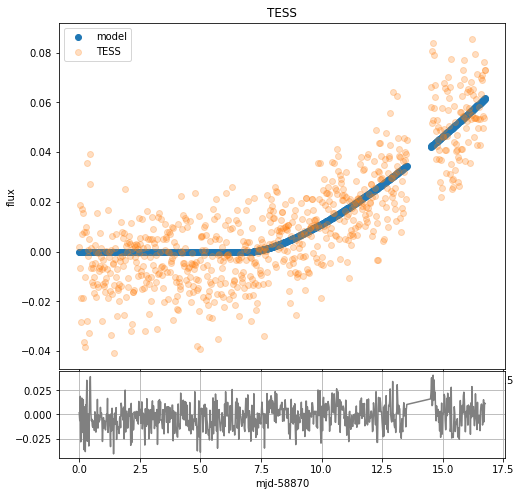

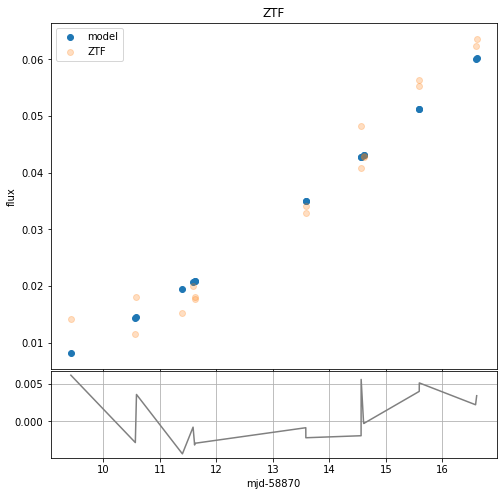

In [101]:
guess = {'t0':7.132,'a':.002495,'power':1.416099}
cutoff = 16.75
plot_lc_model(guess,tess_2020bpi,cutoff)
plot_lc_model(guess,ztf_2020bpi,cutoff)

In [17]:
# plt.scatter(tess_2020bpi[tess_2020bpi.flux >=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux >=0].flux.rolling(48).median(),
#            )
# plt.scatter(tess_2020bpi[tess_2020bpi.flux <=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux <=0].flux.rolling(48).median(),
#            )
# plt.xlim(0,17)
# plt.grid()

# len(tess_2020bpi[tess_2020bpi.flux <=0][tess_2020bpi.mjd_0 <28])/len(tess_2020bpi[tess_2020bpi.mjd_0 <28])

sampling...



done


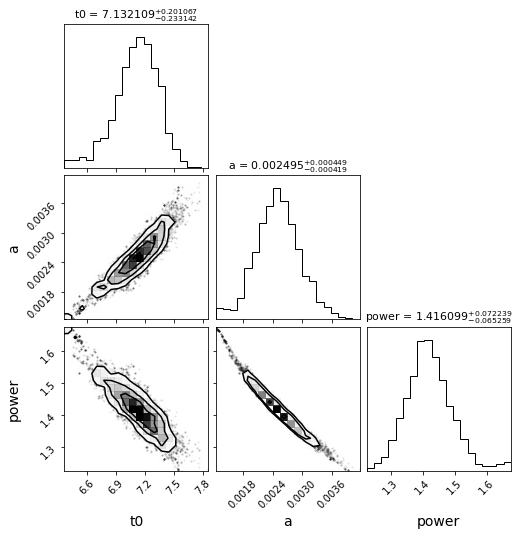

In [98]:
guess = {'t0':7, 'a':0.0025,'power':1.4} ## t0, a, sigma, power
scale = {'t0':0.2, 'a':0.0001,'power':0.1}
doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, nwalkers=50,nburn=300,nsteps=500);

sampling...



done


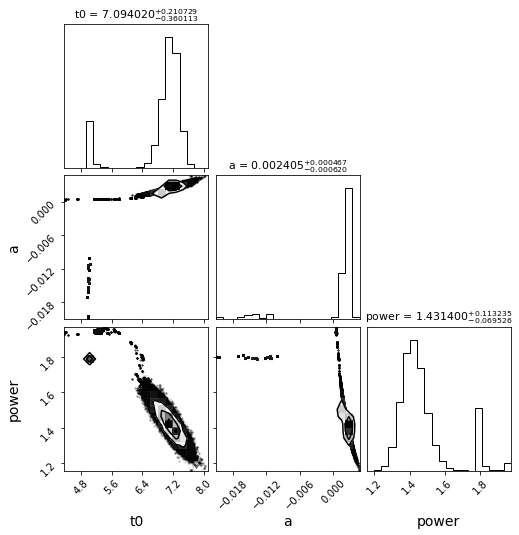

In [92]:
guess = {'t0':5, 'a':0.001,'power':1.8} ## t0, a, sigma, power
scale = {'t0':0.01, 'a':0.01,'power':0.01}
doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, nwalkers=150,nburn=3000,nsteps=10000);

sampling...



done


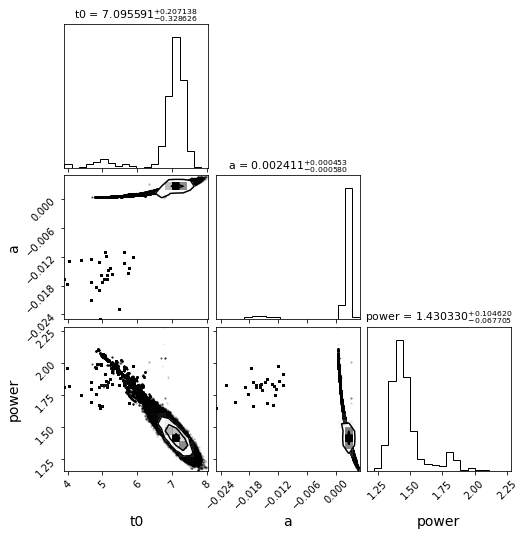

In [96]:
guess = {'t0':5, 'a':0.001,'power':1.8} ## t0, a, sigma, power
scale = {'t0':0.5, 'a':0.01,'power':0.1}
doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, nwalkers=250,nburn=2500,nsteps=20000);